##  First go at a real SAR Processor

###  Eric Sutherland
### 2/15/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy as sc
import os
from scipy.signal import chirp
from scipy.interpolate import interp1d
from simplekml import Kml
import time
import re
import pandas as pd

import functions as fun
import novatel_functions as nov


# %matplotlib widget

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.family" : "serif",
          "font.serif" : ["times new roman"],
          "figure.dpi" : 100}
plt.rcParams.update(params)

%matplotlib widget

# Important constants that change with datasets #

In [2]:

###  Number of files and how much data to import  ###
start_file = 620#100 # 600
stop_file = 660#200  # 680
start_sample = 000
stop_sample = 30000

num_files = stop_file - start_file
# stop_sample = 24000

## Platform attitude basics  ##
# vp = 72  ## Platform velocity in [m/s]
# H = 2000  ## Platform height [m]
# theta_ = np.radians(45)  ## estimated look angle
# bw_el = np.radians(45)  ##  estimating elevation beamwidth
# swath_width = 10000  ## desired swath width in [m]

vp = 60  ## Platform velocity in [m/s]
H = 980  ## Platform height [m]
theta_ = np.radians(45)  ## estimated look angle
bw_el = np.radians(45)  ##  estimating elevation beamwidth
swath_width = 10000  ## desired swath width in [m]

## Constants  ##
c = 3e8
num_plots = 25  ## helps to determine how many lines to plot (fewer speeds things up)

##  radar parameters  ##
f0 = 5.39e9
# f0 = 13.64e9
prf = 1e3
lambda_ = c/f0


## Compression parameters  ##
fs = 491.52e6*2

###  For NH Data  ###
# fl = 240e6
# fh = 320e6
# tp = 5.7e-6

###  For CO Data  ###
fl = 143e6
fh = 223e6
tp = 11e-6


chirp_direction = 'up'
B = fh - fl



In [3]:
directory = r'\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359'  ####  CBand in NH over airport
# directory = r'\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T142814'  ### CBand NH december
# directory = r'\\seasat\Projects\SNOWWI\Colorado_January\20240205T020242\chan0'  ####  CBand in Grand Junction
# directory = r'\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T120951\chan0'  ### CBand CO March
# directory = r'\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T124951\chan0'  ### CBand CO March
directory = r'\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T123855\chan2'  ### CBand CO March
# directory = r'\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T125534\chan2'


# directory = r'\\seasat\Projects\SNOWWI\Colorado_January\20240204T193523\chan0'  ####  Ku Low in Grand Junction

# directory = r'\\Sentinel\SNOWWI\Colorado2024\January\Radar_data\save_data_nvme0\20240205T031232\chan0'  ####  CBand in Grand Mesa


filelist = fun.list_files(directory)

rawdata = fun.load_data(filelist, start_file, stop_file, start_sample=start_sample, stop_sample=stop_sample)



Files with keyword: rcv
-----------------------------------------------------------------------------------
\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T123855\chan2\receive_0000000000000000_1711557559.391531.dat
\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T123855\chan2\receive_0000000000000500_1711557559.891531.dat
\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T123855\chan2\receive_0000000000001000_1711557560.391531.dat
\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T123855\chan2\receive_0000000000001500_1711557560.891531.dat
\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T123855\chan2\receive_0000000000002000_1711557561.391531.dat
\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T123855\chan2\receive_0000000000002500_1711557561.891531.dat
\\Sentinel

In [4]:


# novatel_directory = r'\\Sentinel\SNOWWI\Colorado2024\March\Novatel'
# novatel_filename = r'gm_20240327.txt'

# header = nov.get_header(filelist[start_file])
# unix_start_time = nov.timestamp_from_header(header) + 7200

# gps_to_unix = 315964800

# gps_start_time = unix_start_time - gps_to_unix
# gps_stop_time = gps_start_time + num_files/2

# novatel = nov.readNovatel(novatel_directory, novatel_filename, gps_start_time, gps_stop_time)


In [5]:
# novatel_directory = r'\\Sentinel\SNOWWI\Colorado2024\March\Novatel'
# novatel_filename = r'gm_20240327.txt'

# flightline = nov.readNovatel(novatel_directory, novatel_filename, gps_start_time, gps_stop_time)
# base_time, base_dt = nov.get_time(flightline)

# yaw, pitch, roll = nov.get_yaw_pitch_roll(flightline)
# yaw, pitch, roll, time = nov.interpolate_attitude(yaw, pitch, roll, base_time, base_dt, rawdata.shape[0])

# x, y, z = nov.get_xyz(flightline)
# xfit, yfit, zfit = nov.fit_position(x, y, z)

# xfit, yfit, zfit, _ = nov.interpolate_xyz(xfit, yfit, zfit, base_time, base_dt, rawdata.shape[0])

# dt = 1/prf


In [6]:
# dx = np.diff(xfit)
# dy = np.diff(yfit)
# dz = np.diff(zfit)

# ds = np.sqrt(dx**2 + dy**2 + dz**2)
# s = np.cumsum(ds)
# vp = ds/dt

# vp_mean = np.mean(vp)

In [7]:
###  Plotting raw radar data  ###
# %matplotlib widget

# n = int(rawdata.shape[0]/num_plots)

# plt.figure(figsize=(16, 4))

# for i in rawdata[0::n]:
#     plt.plot(i)



# plt.title(f'{num_plots} Raw Pulses - Sanity Check')
# plt.xlabel('Range Samples')
# plt.ylabel('Magnitude Samples')

# plt.xlim(0, rawdata.shape[1])

# plt.grid()
# plt.show()

In [8]:
rawdata -= rawdata.mean(axis=1, ).reshape(-1, 1)

In [9]:
# rawdata = rawdata[:-2500]

In [10]:
print(rawdata.shape)

(20000, 30000)


In [11]:
###  Compressing and plotting compression waveforms  ###

rawdata = fun.bandpass(rawdata, fl-10e6, fh+10e6, fs, 3)
compressed = fun.compress(rawdata, tp, fs, fl, fh, chirp_direction, plot=False)

print(rawdata.dtype)
del(rawdata)

Chirp Samples: 10813
Created Reference Signals... Now to Compress
60.547669887542725
Finished Compressing...
float64


In [12]:
# n = int(rawdata.shape[0]/num_plots)
# %matplotlib widget


# plt.figure(figsize=(16, 4))

# plt.plot(20*np.log10(abs(compressed[10])))

# plt.grid()
# plt.show()

In [13]:
### Truncate swath to be just returns  ###

# swath, Rmin, Rmax = truncate_swath(compressed, swath_width, H, tp, fs, theta_, bw_el)
# swath = compressed[:, start_sample+30000:]
swath = compressed[:, start_sample+21500:]
# swath = compressed[:, 19300:]
# swath = compressed[:, 12900:]
del(compressed)



In [14]:
# Rmin = flightline['H-Ell'].mean() - (10000/3.25)
Rmin = 980
Rmax = Rmin + ((c/fs)*swath.shape[1])/2
R = np.linspace(Rmin, Rmax, swath.shape[1]) / 1000

print(Rmin)
print(Rmax)

980
2276.9970703125


In [15]:
print(swath.shape)
# print(s.shape)

(20000, 8500)


###  Resample each range line in azimuth  ###

In [16]:
# alongtrack = np.linspace(s[0], s[-1], len(s))

# for i in range(swath.shape[1]):
#     interpolator = interp1d(s, swath[:, i], kind='cubic', fill_value='extrapolate')
#     swath[:, i] = interpolator(alongtrack)
# swath = swath[:-2000]

In [17]:
swath.shape
# newswath = swath[3:]

(20000, 8500)

In [18]:
# newswath.shape

In [19]:
newCentroids = []


for chunk in np.split(swath, 10, axis=0):
    chunk_fft = np.fft.fftshift(sc.fft.fft(chunk, axis=0), axes=0).astype(np.complex64)
    doppler_fit, doppler_centroids = fun.fit_doppler(chunk_fft, prf, fs, 300, 1, False)

    doppler_centroids = fun.rolling_avg(doppler_centroids, 100)
    newCentroids.append(doppler_centroids)




In [20]:
az_fft_data = np.fft.fftshift(sc.fft.fft(swath, axis=0)[3:-3], axes=0).astype(np.complex64)


In [21]:
az_fft_multi = fun.multilook(abs(az_fft_data), 4, 10)
# multilooked.shape

In [22]:
print(max(20*np.log10(abs(az_fft_multi.flatten()))))

158.22566


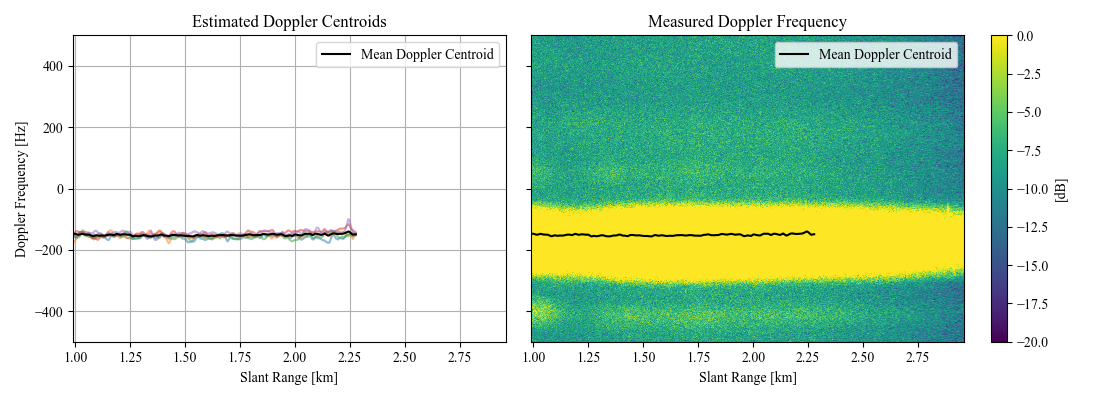

In [23]:
%matplotlib widget

newCentroids = np.array(newCentroids)
multilooked = fun.multilook(newCentroids, 4, 1)
avgCentroid = np.mean(multilooked, axis=0)

R = np.linspace(Rmin, Rmax, multilooked.shape[1])/1000

fig, ax = plt.subplots(figsize=[11, 4], nrows=1, ncols=2, sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1.25]})

im = ax[1].imshow(20*np.log10(abs(az_fft_multi)) - 135, vmin=-20, vmax=0, origin='lower', interpolation='None', cmap='viridis', aspect='auto', extent=[(Rmin+10)/1000, (Rmin+1980)/1000, -prf/2, prf/2])

ax[1].plot(R, avgCentroid, color='k', label='Mean Doppler Centroid')
ax[1].set_title('Measured Doppler Frequency')
ax[1].set_xlabel('Slant Range [km]')
fig.colorbar(im, ax=ax[1], label='[dB]')






for i in multilooked[::2]:
    ax[0].plot(R, i, alpha=0.5)

ax[0].plot(R, avgCentroid, color='k', label='Mean Doppler Centroid')

# ax[1].settitle('Doppler Frequency vs. Slant Range')
ax[0].set_title('Estimated Doppler Centroids')
ax[0].set_ylabel('Doppler Frequency [Hz]')
ax[0].set_xlabel('Slant Range [km]')

# ax[1].ylim(-prf/2, prf/2)
ax[0].set_xlim((Rmin+10)/1000, (Rmin+1980)/1000)
ax[0].grid()

ax[0].legend()
ax[1].legend()


fig.tight_layout()

# image_file = f'CBand_NH_Doppler.pdf'
# plt.savefig(os.path.join(r'C:\Users\epsutherland\Desktop\ForThesis', image_file), dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)
plt.show()

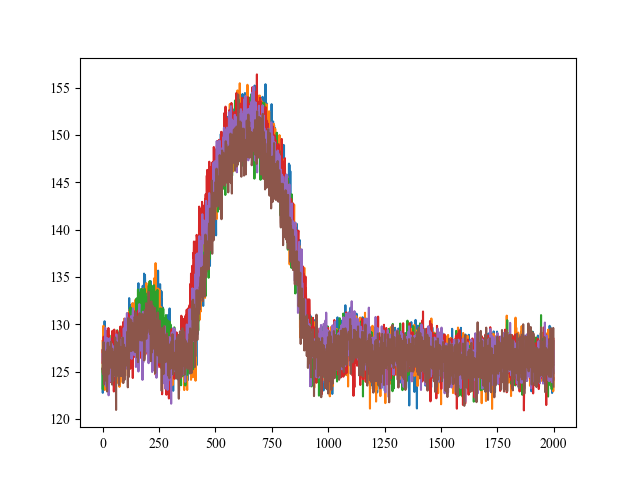

In [27]:
plt.figure()

plt.plot(20*np.log10(abs(az_fft_multi[:, 10])))
plt.plot(20*np.log10(abs(az_fft_multi[:, 20])))
plt.plot(20*np.log10(abs(az_fft_multi[:, 40])))
plt.plot(20*np.log10(abs(az_fft_multi[:, 600])))
plt.plot(20*np.log10(abs(az_fft_multi[:, 400])))

plt.plot(20*np.log10(abs(az_fft_multi[:, 100])))

plt.show()

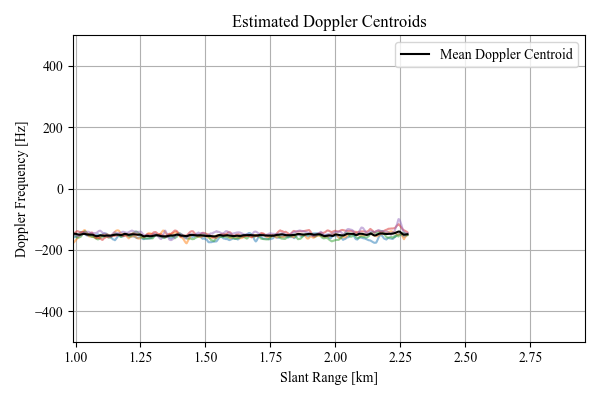

In [24]:
newCentroids = np.array(newCentroids)
multilooked = fun.multilook(newCentroids, 4, 1)
avgCentroid = np.mean(multilooked, axis=0)

R = np.linspace(Rmin, Rmax, multilooked.shape[1])/1000

fig, ax = plt.subplots(figsize=[6, 4], nrows=1, ncols=1, sharex=True, sharey=True)

# im = ax[1].imshow(20*np.log10(abs(az_fft_multi)) - 135, vmin=-20, vmax=0, origin='lower', interpolation='None', cmap='viridis', aspect='auto', extent=[(Rmin+10)/1000, (Rmin+1980)/1000, -prf/2, prf/2])

# ax[1].plot(R, avgCentroid, color='k', label='Mean Doppler Centroid')
# ax[1].set_title('Measured Doppler Frequency')
# ax[1].set_xlabel('Slant Range [km]')
# fig.colorbar(im, ax=ax[1], label='[dB]')






for i in multilooked[::2]:
    ax.plot(R, i, alpha=0.5)

ax.plot(R, avgCentroid, color='k', label='Mean Doppler Centroid')

# ax[1].settitle('Doppler Frequency vs. Slant Range')
ax.set_title('Estimated Doppler Centroids')
ax.set_ylabel('Doppler Frequency [Hz]')
ax.set_xlabel('Slant Range [km]')

ax.set_ylim(-prf/2, prf/2)
ax.set_xlim((Rmin+10)/1000, (Rmin+1980)/1000)
ax.grid()

ax.legend(loc='upper right')
# ax[1].legend()


fig.tight_layout()

# image_file = f'Doppler_peaks_NH.pdf'
# plt.savefig(os.path.join(r'C:\Users\epsutherland\Desktop\ForThesis', image_file), dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)
plt.show()

In [ ]:
newCentroids = np.array(newCentroids)
multilooked = fun.multilook(newCentroids, 4, 1)
avgCentroid = np.mean(multilooked, axis=0)

R = np.linspace(Rmin, 4800, multilooked.shape[1])/1000

fig, ax = plt.subplots(figsize=[6.2, 4], nrows=1, ncols=1, sharex=True, sharey=True)

im = ax.imshow(20*np.log10(abs(az_fft_multi)) - 142, vmin=-20, vmax=0, origin='lower', interpolation='None', cmap='viridis', aspect='auto')#, extent=[(Rmin+10)/1000, (4800)/1000, -prf/2, prf/2])

ax.plot(R, avgCentroid, color='k', label='Mean Doppler Centroid')
ax.set_title('Measured Doppler Frequency')
ax.set_ylabel('Doppler Frequency [Hz]')

ax.set_xlabel('Slant Range [km]')
# ax.set_xlim((Rmin+10)/1000, (Rmin+1980)/1000)

fig.colorbar(im, ax=ax, label='[dB]')






# for i in multilooked[::2]:
#     ax[0].plot(R, i, alpha=0.5)

# ax[0].plot(R, avgCentroid, color='k', label='Mean Doppler Centroid')

# # ax[1].settitle('Doppler Frequency vs. Slant Range')
# ax[0].set_title('Estimated Doppler Centroids')
# ax[0].set_ylabel('Doppler Frequency [Hz]')
# ax[0].set_xlabel('Slant Range [km]')

# # ax[1].ylim(-prf/2, prf/2)
# ax[0].set_xlim((Rmin+10)/1000, (Rmin+1980)/1000)
# ax[0].grid()

# ax[0].legend()
ax.legend()


fig.tight_layout()

image_file = f'Measured_Doppler_NH.pdf'
plt.savefig(os.path.join(r'C:\Users\epsutherland\Desktop\ForThesis\GM_CReflectors', image_file), dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)
plt.show()

In [ ]:
%matplotlib widget

newCentroids = np.array(newCentroids)
multilooked = fun.multilook(newCentroids, 4, 1)
avgCentroid = np.mean(multilooked, axis=0)

R = np.linspace(Rmin, Rmax, multilooked.shape[1])/1000

plt.figure()

for i in multilooked[::2]:
    plt.plot(R, i, alpha=0.5)

plt.plot(R, avgCentroid, color='k', label='Mean Doppler Offset')

plt.title('Doppler Frequency vs. Slant Range')
plt.ylabel('Doppler Frequency [Hz]')
plt.xlabel('Slant Range [km]')

plt.ylim(-prf/2, prf/2)
plt.xlim((Rmin+10)/1000, (Rmin+1980)/1000)
plt.legend()
plt.grid()

# image_file = f'CBand_NH_Doppler.pdf'
# plt.savefig(os.path.join(r'C:\Users\epsutherland\Desktop\ForThesis', image_file), dpi=1000, bbox_inches='tight', pad_inches=0.25, transparent=False)
plt.show()

In [ ]:
newCentroids[1].shape

In [ ]:
# x = [1, 2, 3, 4]

# print(x[:3])

In [ ]:
###  Plotting image of compressed data

# %matplotlib inline

# n = int(swath.shape[0]/num_plots)



# fig, ax = plt.subplots(figsize=[16, 4], nrows=1, ncols=2)

# im = ax[0].imshow(20*np.log10(abs(swath)), vmin=90, vmax=120, origin='lower', interpolation='None', cmap='gray', aspect='equal')
# ax[0].set_title('Compressed Data')
# ax[0].set_xlabel('Range Samples')
# ax[0].set_ylabel('Azimuth Samples')
# fig.colorbar(im, ax=ax[0], label='[dB]')

# for i in swath[::n]:
#     ax[1].plot(20*np.log10(abs(i)), alpha=0.3)

# ax[1].set_title('Compressed Range Lines')
# ax[1].set_xlabel('Range Samples')
# ax[1].set_ylabel('[dB]')
# ax[1].set_xlim(0, swath.shape[1])
# ax[1].grid()

# plt.show()

In [ ]:
# %matplotlib widget

# plt.figure()

# plt.imshow(20*np.log10(abs(swath)), vmin=90, vmax=120, origin='upper', interpolation='None', cmap='gray', aspect='equal')

# image_file = f'compressed1.png'
# cwd = os.getcwd()

# plt.savefig(os.path.join(cwd, image_file), dpi=1000, bbox_inches='tight', pad_inches=0, transparent=True)

# plt.colorbar()
# plt.show()

## Azimuth FFT  ##

In [ ]:
###  Finding Azimuth FFT  ###

# swath = multilook(swath, 4, 1)

az_samples = swath.shape[0]
T_az = 1/prf
az_tmin = 0
az_tmax = T_az*az_samples

# t_az = np.linspace(az_tmin, az_tmax, az_samples)
# az_fft_data = np.fft.fftshift(sc.fft.fft(swath, axis=0), axes=0).astype(np.complex64)

# az_freq = np.linspace(-prf/2, prf/2, az_samples)
# freq_khz = az_freq/1e3
# print(az_fft_data.dtype)
# del(swath)


In [ ]:
print(az_samples)

In [ ]:
# az0 = swath[0:7500]
# az1 = swath[7500:15000]
# az2 = swath[15000:22500]
# az3 = swath[22500:30000]

# az_fft_0 = np.fft.fftshift(sc.fft.fft(az0, axis=0), axes=0).astype(np.complex64)
# az_fft_1 = np.fft.fftshift(sc.fft.fft(az1, axis=0), axes=0).astype(np.complex64)
# az_fft_2 = np.fft.fftshift(sc.fft.fft(az2, axis=0), axes=0).astype(np.complex64)
# az_fft_3 = np.fft.fftshift(sc.fft.fft(az3, axis=0), axes=0).astype(np.complex64)




In [ ]:
directory = r'C:\Users\epsutherland\Desktop\ForThesis'

rng_samples = 1083
az_samples = 18750

NH_slc = fun.read_SNOWWI_SLC(directory, 'Final_slc_NH_Airport_slc.dat', az_samples, rng_samples)


NH_slc = NH_slc[8063:14438]
NH_slc = fun.multilook(NH_slc, 1, 10)

In [ ]:
# vmax = 130
# vmin = 110

# fig, ax = plt.subplots(4, 2, figsize=([4, 8]), sharex=True, sharey=True)
# im0 = ax[0,0].imshow(20*np.log10(abs(az_fft_0)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')#, extent=[Rminkm, Rmaxkm, azmaxkm, azminkm])
# # ax[0].set_ylabel('Along Track [km]')
# # fig.colorbar(im0, ax=ax[0], shrink=0.75, label='[dB - Uncal.]')

# im1 = ax[1,0].imshow(20*np.log10(abs(az_fft_1)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')#, extent=[Rminkm, Rmaxkm, azmaxkm, azminkm])
# # ax[1].set_xlabel('Slant Range [km]')
# # ax[1].set_ylabel('Along Track [km]')

# # fig.colorbar(im1, ax=ax[1], shrink=0.75, label='[dB - Uncal.]')

# im2 = ax[2,0].imshow(20*np.log10(abs(az_fft_2)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')#, extent=[Rminkm, Rmaxkm, azmaxkm, azminkm])

# im3 = ax[3,0].imshow(20*np.log10(abs(az_fft_3)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')#, extent=[Rminkm, Rmaxkm, azmaxkm, azminkm])
# ax[3,0].set_xlabel('Slant Range [km]', fontsize=10)

# im5 = ax[:, 1].imshow(20*np.log10(abs(NH_slc)), vmin=vmin, vmax=vmax, origin='lower', cmap='gray',  interpolation='bilinear', aspect='equal')



# # vmax=183
# # vmin=vmax-25


# # bias = vmax-5
# # vmin -= bias
# # vmax -= bias


# # im = ax[:, 1].imshow(20*np.log10(abs(NH_slc)) - bias, vmin=vmin, vmax=vmax, origin='lower', cmap='gray',  interpolation='bilinear', aspect='equal', extent=[Rminkm, Rmaxkm, azminkm, azmaxkm])
# # ax[:, 1].set_xlabel('Slant Range [km]')



# # fig.suptitle(f'C-Band Grand Mesa 3-27-2024')
# fig.tight_layout()
# # fig.colorbar(im0, ax=ax.ravel().tolist(), label='[dB - Uncal.]', aspect=50)

# # fig.supxlabel('Slant Range [km]')
# fig.supylabel('Along Track [km]', fontsize=10)



# # image_file = f'CBand_withMoCo_new_DR_vertical.pdf'
# # plt.savefig(os.path.join(directory, image_file), dpi=1000, bbox_inches='tight', pad_inches=0.25, transparent=False)


# plt.show()

In [ ]:
# vmax = 130
# vmin = 110

# fig, ax = plt.subplots(4, 2, figsize=([4, 8]), sharex=True, sharey=True)
# im0 = ax[0,0].imshow(20*np.log10(abs(az_fft_0)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')#, extent=[Rminkm, Rmaxkm, azmaxkm, azminkm])
# # ax[0].set_ylabel('Along Track [km]')
# # fig.colorbar(im0, ax=ax[0], shrink=0.75, label='[dB - Uncal.]')

# im1 = ax[1,0].imshow(20*np.log10(abs(az_fft_1)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')#, extent=[Rminkm, Rmaxkm, azmaxkm, azminkm])
# # ax[1].set_xlabel('Slant Range [km]')
# # ax[1].set_ylabel('Along Track [km]')

# # fig.colorbar(im1, ax=ax[1], shrink=0.75, label='[dB - Uncal.]')

# im2 = ax[2,0].imshow(20*np.log10(abs(az_fft_2)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')#, extent=[Rminkm, Rmaxkm, azmaxkm, azminkm])

# im3 = ax[3,0].imshow(20*np.log10(abs(az_fft_3)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')#, extent=[Rminkm, Rmaxkm, azmaxkm, azminkm])
# ax[3,0].set_xlabel('Slant Range [km]', fontsize=10)

# im5 = ax[:, 1].imshow(20*np.log10(abs(NH_slc)), vmin=vmin, vmax=vmax, origin='lower', cmap='gray',  interpolation='bilinear', aspect='equal')



# # vmax=183
# # vmin=vmax-25


# # bias = vmax-5
# # vmin -= bias
# # vmax -= bias


# # im = ax[:, 1].imshow(20*np.log10(abs(NH_slc)) - bias, vmin=vmin, vmax=vmax, origin='lower', cmap='gray',  interpolation='bilinear', aspect='equal', extent=[Rminkm, Rmaxkm, azminkm, azmaxkm])
# # ax[:, 1].set_xlabel('Slant Range [km]')



# # fig.suptitle(f'C-Band Grand Mesa 3-27-2024')
# fig.tight_layout()
# # fig.colorbar(im0, ax=ax.ravel().tolist(), label='[dB - Uncal.]', aspect=50)

# # fig.supxlabel('Slant Range [km]')
# fig.supylabel('Along Track [km]', fontsize=10)



# # image_file = f'CBand_withMoCo_new_DR_vertical.pdf'
# # plt.savefig(os.path.join(directory, image_file), dpi=1000, bbox_inches='tight', pad_inches=0.25, transparent=False)


# plt.show()

# for tl, cl in zip([True, False, False], [False, False, True]):

vmin=110
vmax=130

fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(4, 3)

ax = dict()

ax['A'] = fig.add_subplot(gs[0, 0:2])
ax['B'] = fig.add_subplot(gs[1, 0:2], sharex=ax['A'])
ax['C'] = fig.add_subplot(gs[2, 0:2], sharex=ax['A'])
ax['D'] = fig.add_subplot(gs[3, 0:2], sharex=ax['A'])

ax['E'] = fig.add_subplot(gs[:, 2])

ax['A'].imshow(20*np.log10(abs(az_fft_3)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')
ax['B'].imshow(20*np.log10(abs(az_fft_2)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')
ax['C'].imshow(20*np.log10(abs(az_fft_1)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')
ax['D'].imshow(20*np.log10(abs(az_fft_0)), cmap='viridis', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear', extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')

ax['E'].imshow(20*np.log10(abs(NH_slc)), cmap='gray', vmin=20, vmax=40, origin='lower', interpolation='bilinear', aspect='equal')#, extent=[0, az_fft_0.shape[1], -prf/2, prf/2], aspect='auto')


    # ax['C'].set_xlabel('Booger')
    # ax['B'].set_xlabel('Booger')
    # ax['A'].set_ylabel('Booger Y')
    # fig.suptitle(f'TEST: tight_layout={tl} constrained_layout={cl}')
    # fig.supxlabel('XLAgg')
    # fig.supylabel('YLAgg')
    
plt.show()


In [ ]:
1.875 * 1083

In [ ]:
# ###  Plotting some Azimuth FFT Stuffs  ###

vmin = 110
vmax = 130

# vmin = 140
# vmax = 160

n = int(az_fft_data.shape[1]/num_plots)

fig, ax = plt.subplots(figsize=[16, 4], nrows=1, ncols=2)

im = ax[0].imshow(20*np.log10(abs(az_fft_data)), vmin=vmin, vmax=vmax, origin='lower', interpolation='None', extent=[0, az_fft_data.shape[1], -prf/2, prf/2], aspect='auto')
ax[0].set_title('Azimuth Frequency Spectrogram')
ax[0].set_xlabel('Range Samples')
ax[0].set_ylabel('Azimuth Frequency [Hz]')
fig.colorbar(im, ax=ax[0], label='[dB]')

for i in az_fft_data.T[::n]:
    ax[1].plot(az_freq, 20*np.log10(abs(i)), alpha=0.3)

ax[1].set_title('Azimuth Frequency of Different Range Lines')
ax[1].set_xlabel('Azimuth Frequency [Hz]')
ax[1].set_ylabel('[dB]')
ax[1].set_xlim(-prf/2, prf/2)
ax[1].grid()

plt.show()

###  Applying Range Cell Migration Corrections  ###

In [ ]:
# az_fft_data = az_fft_data[:, 0:12000]

range_corrected_rd = fun.rcmc(az_fft_data, lambda_, prf, fs, Rmin, Rmax, vp_mean).astype(np.complex64)
print(range_corrected_rd.dtype)
del(az_fft_data)

In [ ]:
range_corrected_rd.shape

## Smoothing Doppler, finding Doppler Centroids  ##

In [ ]:
# def fit_doppler(data, prf, fs, B, order, snr=True):


#     smoothed_doppler, range_corrected_rd = fun.smooth_doppler(data, fs, B)  ##  Running some rolling averages over azimuth doppler centroids
#     az_freq = np.linspace(-prf/2, prf/2, data.shape[0])

#     doppler_centroid_idx = np.argmax(smoothed_doppler, axis=0)

#     if snr == True:
#         means = np.mean(abs(smoothed_doppler), axis=0)
#         maxs = np.max(abs(smoothed_doppler), axis=0)

#         badsnr = np.where(maxs<(1.3*means))[0]  ## Finding indeces where snr < ...dB

#         doppler_centroid_idx[badsnr[0]:] = doppler_centroid_idx[badsnr[0] - 1]  ## replacing indeces with bad snr to the last index with a good snr
    
#     doppler_centroids = az_freq[doppler_centroid_idx]

#     range_samples = np.linspace(0, doppler_centroids.shape[0]-1, doppler_centroids.shape[0])

#     coeff = np.polyfit(range_samples, doppler_centroids, 1)
#     doppler_fit = coeff[0]*range_samples + coeff[1]  # **3 + coeff[1]*range_samples**2 + coeff[2]*range_samples + coeff[3]

#     return doppler_fit, range_corrected_rd, doppler_centroids




In [ ]:
doppler_fit, doppler_centroids = fun.fit_doppler(range_corrected_rd, prf, fs, 300, 3, False)
# doppler_fit, doppler_centroids = fun.fit_doppler(range_corrected_rd, prf, fs, B, 1, False)

# doppler_fit +=50

print(doppler_fit.dtype)
print(doppler_centroids.dtype)

In [ ]:
plt.figure()

plt.plot(doppler_fit)
plt.plot(doppler_centroids)

plt.show()

In [ ]:
###  Plotting some Azimuth FFT Stuffs  ###

# vmin = 110
# vmax = 130

# # vmin = 140
# # vmax = 160

# n = int(range_corrected_rd.shape[1]/num_plots)

# plt.figure()

# im = plt.imshow(20*np.log10(abs(range_corrected_rd)), vmin=vmin, vmax=vmax, origin='lower', interpolation='None', extent=[0, range_corrected_rd.shape[1], -prf/2, prf/2], aspect='auto')
# plt.plot(doppler_fit, color='r', linewidth=0.8)
# plt.plot(doppler_centroids, color='k', linewidth=0.8)
# plt.title('Range Corrected Azimuth Frequency Spectrogram')
# plt.xlabel('Range Samples')
# plt.ylabel('Azimuth Frequency [Hz]')
# plt.colorbar(im, label='[dB]')

# # for i in range_corrected_rd.T[::n]:
# #     ax[1].plot(20*np.log10(abs(i)), alpha=0.3)

# # ax[1].set_title('Azimuth Frequency of Different Range Lines')
# # ax[1].set_xlabel('Azimuth Frequency [Hz]')
# # ax[1].set_ylabel('[dB]')
# # ax[1].set_xlim(-prf/2, prf/2)
# # ax[1].grid()

# plt.show()

In [ ]:
# smoothed_doppler, range_corrected_rd = smooth_doppler(range_corrected_rd, fs, B)  ##  Running some rolling averages over azimuth doppler centroids

# doppler_centroid_idx = np.argmax(smoothed_doppler, axis=0)
# doppler_centroids = az_freq[doppler_centroid_idx]

# range_samples = np.linspace(0, doppler_centroids.shape[0]-1, doppler_centroids.shape[0])

# coeff = np.polyfit(range_samples, doppler_centroids, 3)
# doppler_fit = coeff[0]*range_samples**3 + coeff[1]*range_samples**2 + coeff[2]*range_samples + coeff[3]

# doppler_fit = coeff[0]*range_samples**5 + coeff[1]*range_samples**4 + coeff[2]*range_samples**3 + coeff[3]*range_samples**2 + coeff[4]*range_samples + coeff[5]
# doppler_fit = coeff[0]*range_samples**2 + coeff[1]*range_samples + coeff[2]




In [ ]:
# def rcmc(data, lambda_, fs_az, fs_rng, Rmin, Rmax, vp):

#     az_samp = data.shape[0]
#     rng_samp = data.shape[1]

#     y = np.arange(az_samp)
#     x = np.arange(rng_samp)

#     fn = np.linspace(-fs_az/2, fs_az/2, az_samp)

#     # R0 = (Rmin + Rmax) / 2

#     R = np.linspace(Rmin, Rmax, rng_samp).reshape((-1, rng_samp))
#     fn = (np.linspace(-fs_az/2, fs_az/2, az_samp)**2).reshape((az_samp, -1))  ## squared because of range migration equation
#     Rfn = fn.dot(R)
#     dR = (lambda_**2 * Rfn) / (8*vp**2)

#     Rshift = (2*dR*fs_rng) / 3e8
#     # Rshift = x - np.array(shift_samples)[:, np.newaxis]

#     new_matrix = np.zeros_like(data)

#     # print(Rshift)
#     # return Rshift
#     xin = np.arange(rng_samp)
    
#     for i in range(az_samp):
#         x = xin - Rshift[i, :]
#         interp_func = interp1d(x, data[i], kind='cubic', bounds_error=False, fill_value=1)
#         new_matrix[i] = interp_func(np.arange(rng_samp))
    
#     return new_matrix


In [ ]:
# rd_corrections = rcmc(az_fft_data, lambda_, prf, Rmin, Rmax, vp)  ##  this matrix is the phase corrections that need to be applied
# range_corrected_rd = az_fft_data*rd_corrections




In [ ]:
# %matplotlib widget

# plt.figure(figsize=(9, 4))
# plt.imshow(20*np.log10(abs(range_corrected_rd)), vmin=130, vmax=150, origin='lower', cmap='viridis', interpolation='None')
# plt.colorbar()
# plt.show()

In [ ]:
###  Plotting some Azimuth FFT Stuffs  ###

# vmin = 130
# vmax = 150

# # vmin = 140
# # vmax = 160

# n = int(az_fft_data.shape[1]/num_plots)

# fig, ax = plt.subplots(figsize=[16, 4], nrows=1, ncols=2)

# im = ax[0].imshow(20*np.log10(abs(range_corrected_rd)), vmin=vmin, vmax=vmax, origin='lower', interpolation='None', extent=[0, az_fft_data.shape[1], -prf/2, prf/2], aspect='auto')
# ax[0].plot(doppler_fit, color='k')
# ax[0].set_title('Azimuth Frequency Spectrogram')
# ax[0].set_xlabel('Range Samples')
# ax[0].set_ylabel('Azimuth Frequency [Hz]')
# ax[0].grid()
# # fig.colorbar(im, ax=ax[0], label='[dB]')

# im = ax[1].imshow(20*np.log10(abs(smoothed_doppler)), vmin=vmin, vmax=vmax, origin='lower', interpolation='None', extent=[0, az_fft_data.shape[1], -prf/2, prf/2], aspect='auto')


# ax[1].set_title('Azimuth Frequency of Different Range Lines')
# ax[1].set_xlabel('Azimuth Frequency [Hz]')
# ax[1].set_ylabel('[dB]')
# # ax[1].set_xlim(-prf/2, prf/2)
# ax[1].grid()

# plt.show()

In [ ]:
# range_corrected_rd = range_corrected_rd[1:, :]
del(swath)
# del(az_fft_data)

In [ ]:
R = np.linspace(Rmin, Rmax, range_corrected_rd.shape[1])

dR = (Rmax - Rmin)/range_corrected_rd.shape[1]
azR = dR*range_corrected_rd.shape[0]
# az = np.linspace(0, dR*range_corrected_rd.shape[0], range_corrected_rd.shape[0])


# Rmax = Rmin + ((c/fs)*range_corrected_rd.shape[1])/2



# az_matched_filter = azimuth_compress(az_fft_data, lambda_, prf, prf/2, doppler_fit, Rmin, Rmax, vp)
# doppler_zero = np.zeros_like(doppler_fit)
az_BW = 300


doppler_fit = np.ones_like(doppler_centroids) - 150

az_matched_filter = fun.azimuth_compress(range_corrected_rd, lambda_, prf, az_BW, doppler_fit, Rmin, Rmax, vp_mean).astype(np.complex64)




In [ ]:

print(Rmax)
print(azR)
print(vp)

In [ ]:
# az_matched_filter = azimuth_compress(range_corrected_rd, lambda_, prf, doppler_centroids, Rmin, Rmax, vp, 5)

# focused_rd = np.fft.fftshift(np.fft.fft(zero_doppler, axis=0), axes=0)*az_matched_filter
focused_rd = (range_corrected_rd*az_matched_filter).astype(np.complex64)


# del(az_matched_filter)
# del(range_corrected_rd)
# focused_rd = az_fft_data*az_matched_filter
print(focused_rd.dtype)

In [ ]:
import psutil

psutil.virtual_memory().percent

In [ ]:
# print(az_matched_filter[1])

In [ ]:
# plt.figure()

# plt.imshow(np.angle(range_corrected_rd), interpolation='None', cmap='hsv')

# plt.show()

In [ ]:
# plt.figure()

# plt.imshow(np.angle(az_matched_filter), cmap='hsv', interpolation='None')

# plt.colorbar()
# plt.show()

In [ ]:
# del(range_corrected_rd)
# del(az_matched_filter)
focused = np.fft.ifft(focused_rd, axis=0).astype(np.complex64)
# focused = np.fft.ifft(range_corrected_rd, axis=0)

del(focused_rd)
# focused = rolling_avg(focused, 62, 0)
print(focused.dtype)


In [ ]:
psutil.virtual_memory().percent

In [ ]:
focused_multilook = fun.multilook(abs(focused[:, :]), 1, 4)
L=0.5

focused, range_res, az_res = fun.fix_slc_resolution(focused[:, :], vp_mean, prf, fs, L, fh, fl)


In [ ]:
azR = azR/4

In [ ]:
%matplotlib widget
plt.figure()

plt.imshow(20*np.log10(abs(focused[:, :])), vmin=50, vmax=90, origin='lower', cmap='gray', interpolation='bilinear', aspect='auto')
# plt.imshow(np.angle(focused_rd[6000:7350, 7100:7500]), origin='lower', cmap='hsv', interpolation='None')
# plt.imshow(np.angle(range_corrected_rd[6000:7350, 7100:7500]), origin='lower', cmap='hsv', interpolation='None')
plt.title('C-Band Grand Mesa: March 27, 2024')
plt.xlabel('Slant Range [m]')
plt.ylabel('Along Track [m]')
plt.colorbar(label='[dB - Uncal]')

# image_file = f'CBand_NH_Test2.png'
# cwd = os.getcwd()

# plt.savefig(os.path.join(cwd, image_file), dpi=1000, bbox_inches='tight', pad_inches=0.25, transparent=False)



plt.show()

In [ ]:
outputpath = r'C:\Users\epsutherland\Desktop\ForThesis'
channel='FOCUSED_NOISE'
timestamp='FROM'
# L=0.5

# focused, range_res, az_res = fun.fix_slc_resolution(focused[:, :13000], vp, prf, fs, L, fh, fl)

# fun.write_slc(focused, outputpath, channel, timestamp, start_file, stop_file, vp_mean, H, f0, fs, prf, az_BW, range_res, az_res)

In [ ]:
# scale = max(abs(focused.flatten()))/2**16

In [ ]:
# fun.write_slc(focused, cwd, 'ch2_20240327T123855', start_file, stop_file, vp, H, f0, fs, prf, az_BW)

In [ ]:
# az_samples, range_samples = focused.shape

# ch0 = fun.read_SNOWWI_SLC(r'c:\Users\epsutherland\Downloads\ToLabPC\Jupyter Notebook', 'ch0_test.dat', az_samples, range_samples)
# ch2 = fun.read_SNOWWI_SLC(r'c:\Users\epsutherland\Downloads\ToLabPC\Jupyter Notebook', 'ch2_test.dat', az_samples, range_samples)




In [ ]:
x = range(10)
y1 = [i**2 for i in x]
y2 = [i**3 for i in x]

# Creating subplots
plt.figure(figsize=(12, 6))

# Subplots on the left side
plt.subplot(2, 3, 1)  # 2 rows, 3 columns, plot 1
plt.plot(x, y1)
plt.title('Plot 1')

plt.subplot(2, 3, 2)  # 2 rows, 3 columns, plot 2
plt.plot(x, y2)
plt.title('Plot 2')

plt.subplot(2, 3, 3)  # 2 rows, 3 columns, plot 3
plt.plot(x, y1)
plt.title('Plot 3')

plt.subplot(2, 3, 4)  # 2 rows, 3 columns, plot 4
plt.plot(x, y2)
plt.title('Plot 4')

# Subplot on the right side
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.plot(x, y1)
plt.title('Plot 5')

plt.tight_layout()
plt.show()